## O que é um rag

- é uma técnica que combina dois aspectos importantes da inteligência artificial: a recuperação de informações (retrieval) e a geração de texto (generation).
- essa técnica minimiza problemas que as LLMs enfrentam, como diminuição de alucinações e aumenta credibilidade de geração com dados externos
- o RAG trabalha recuperando chuncks de documentos de conteúdos externos com base em cálculo de similaridade
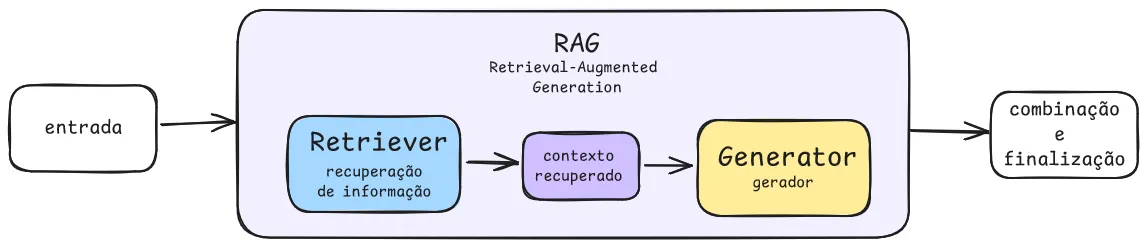


### Retriever
- O retriever é responsável por buscar informações relevantes de uma base de dados ou de um conjunto de documentos. Ele funciona da seguinte maneira:

1. Entrada: Recebe uma consulta (query) que precisa ser respondida.
2. Busca: Utiliza técnicas de recuperação de informações para encontrar documentos ou passagens que são relevantes para a consulta.
3. Saída: Retorna um conjunto de documentos ou passagens que são considerados relevantes para a consulta.


### Generator
O generator é responsável por gerar a resposta final com base nas informações recuperadas pelo retriever. Ele funciona da seguinte maneira:

1. Entrada: Recebe a consulta original e os documentos ou passagens recuperados pelo retriever.
2. Geração: Utiliza um modelo de geração de texto para criar uma resposta que combina a consulta original com as informações recuperadas.
3. Saída: Retorna uma resposta gerada que é informativa e relevante para a consulta.

### Fluxo de Trabalho do RAG

1. Consulta: O usuário faz uma pergunta ou fornece uma consulta.
2. Recuperação: O retriever busca documentos ou passagens relevantes.
3. Geração: O generator utiliza esses documentos para gerar uma resposta.
4. Resposta: A resposta gerada é retornada ao usuário.


## fazendo importação de dependencias, chaves e dataset

In [2]:
%pip install -qU langchain-openai
%pip install langchain_community wikipedia
%pip install openai
%pip install nltk
%pip install rouge_score

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached nltk-3.9.1-py3-none-any.whl.metadata (2.9 kB)
  Using cached click-8.1.7-py3-none-any.whl.metadata (3.0 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
Using cached nltk-3.9.1-py3-none-any.whl (1.5 MB)
Using cached click-8.1.7-py3-none-any.whl (97 kB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Note: you may need to restart the kernel to use updated packages.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=faafc42a0434ee26fce54690a3c2a342b104ad019da1e856b808ace04782cc2d
  Stored in directory: /Users/vx/Library/Caches/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e

In [3]:
from dotenv import load_dotenv
from langchain_community.retrievers import WikipediaRetriever
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
import openai
import os
import gzip
import json

In [4]:
load_dotenv()
api_key = os.getenv('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = api_key

model = "gpt-4o"

## criando retriver

- como criar embeddings e retriever é algo pesado, para facilitar, optei por utilizar um retriever treinado com artigos do wikipedia 
    - essas representações vetoriais de texto (embeddings) são usados tanto para os documentos quanto para a query, permitindo a busca semântica.
- a etapa de recuperação é onde o retriever busca os documentos mais relevantes para uma determinada pergunta
    - documentos semanticamente mais próximas da query do usuário

In [5]:
retriever = WikipediaRetriever()

## criando generator

- uma vez que temos os documentos relevantes, passamos esses documentos para o gerador (no caso, um modelo GPT) que utiliza o conteúdo recuperado para gerar uma resposta. 
- o gerador pode usar os documentos como contexto e então produzir uma resposta mais completa e informada.
    - Prompt: O gerador recebe um prompt que inclui o contexto (os documentos recuperados) e a query original do usuário. O prompt é algo como:
        "Context: {documentos recuperados}\nQuestion: {query}\nAnswer:"

    - GPT: Um modelo de geração de texto que cria uma resposta baseada no contexto fornecido. O modelo GPT tem a capacidade de "preencher" o prompt e gerar texto de forma coerente.

In [6]:
llm = ChatOpenAI(model=model)

In [7]:
prompt = ChatPromptTemplate.from_template(
    """
    You are a Wikipedia assistant.
    Your task is to answer user's questions about anything.
    Try to find the correct instructions and rephrase the answer clearly and concisely.
    Context: {context}
    Question: {question}
    """
)

## montagem do RAG

- com toda estrutura motora pronta, temos a função final para utilizar o rag

In [8]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

In [9]:
def answer_question_with_RAG(question):
    return chain.invoke(question)

## montagem da LLM

- criaremos também uma llm sem retriever para comparar os resultados

In [10]:
def answer_question_with_LLM(question):
        cliente = openai.OpenAI(api_key=api_key)
        messages = [
            {
                "role": "system",
                "content": "You are a Wikipedia assistant. Your task is to answer user's questions about anything. Try to find the correct instructions and rephrase the answer clearly and concisely."
            },
            {
                "role": "user",
                "content": question
            }
        ]

        response = cliente.chat.completions.create(
            model=model,
            messages=messages,
            temperature=0
        )
        return response.choices[0].message.content

## LLM x RAG

In [11]:
pergunta = "who is the announcer on americas got talent"

In [12]:
print("Answer with RAG:")
print(answer_question_with_RAG(pergunta))
print("\nAnswer with LLM:")
print(answer_question_with_LLM(pergunta))

Answer with RAG:
The announcer for America's Got Talent is Bill Hanrahan.

Answer with LLM:
The announcer for "America's Got Talent" is typically Terry Crews, who also serves as the host of the show.


In [13]:
## importando perguntas naturais do google
dados = []
file_path = './nq-dev.jsonl.gz'

with gzip.open(file_path, 'rt', encoding='utf-8') as f:
    for line in f:
        # converter a linha JSON em um dicionário Python
        json_data = json.loads(line)
        dados.append(json_data)

{'annotations': [{'annotation_id': 4140088113231096052,
   'long_answer': {'candidate_index': 26,
    'end_byte': 74261,
    'end_token': 680,
    'start_byte': 72558,
    'start_token': 565},
   'short_answers': [],
   'yes_no_answer': 'NONE'},
  {'annotation_id': 1145256993412059663,
   'long_answer': {'candidate_index': 26,
    'end_byte': 74261,
    'end_token': 680,
    'start_byte': 72558,
    'start_token': 565},
   'short_answers': [],
   'yes_no_answer': 'NONE'},
  {'annotation_id': 14534915353458813114,
   'long_answer': {'candidate_index': 0,
    'end_byte': 66229,
    'end_token': 438,
    'start_byte': 55171,
    'start_token': 40},
   'short_answers': [],
   'yes_no_answer': 'NONE'},
  {'annotation_id': 14478630666132430671,
   'long_answer': {'candidate_index': 26,
    'end_byte': 74261,
    'end_token': 680,
    'start_byte': 72558,
    'start_token': 565},
   'short_answers': [],
   'yes_no_answer': 'NONE'},
  {'annotation_id': 13111850326776158062,
   'long_answer': {
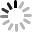

In [14]:
dados[123]['question_text']

In [15]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer


# Função para calcular BLEU Score
def calculate_bleu(reference, candidate):
    return sentence_bleu([reference.split()], candidate.split())

# Função para calcular ROUGE Score
def calculate_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    return scorer.score(reference, candidate)

# Exemplo de avaliação
reference_answer = "Paris is the capital city of France."
candidate_answer = "The capital of France is Paris."

bleu_score = calculate_bleu(reference_answer, candidate_answer)
rouge_score = calculate_rouge(reference_answer, candidate_answer)

print("BLEU Score:", bleu_score)
print("ROUGE Score:", rouge_score)

BLEU Score: 1.2967862918337585e-231
ROUGE Score: {'rouge1': Score(precision=1.0, recall=0.8571428571428571, fmeasure=0.923076923076923), 'rougeL': Score(precision=0.6666666666666666, recall=0.5714285714285714, fmeasure=0.6153846153846153)}


/Users/vx/Desktop/coding/machineLearning/.venv/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/vx/Desktop/coding/machineLearning/.venv/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/vx/Desktop/coding/machineLearning/.venv/lib/python3.12/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlap